In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np

import re
import os
import csv

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate

In [0]:
path = "drive/capstone/"

In [0]:
data = pd.read_csv(path+"data_clean/data_clean.csv")

In [14]:
data.head()

,Date,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,rise_CCL,change_CCL,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change
0,2017-04-30,155.45,158.924455,154.57,158.509801,1,0.569321,-6.586486,0.000000,-1.110520,-0.244676,0.000000
1,2017-04-23,154.57,158.509801,152.77,157.963331,1,1.178242,-5.992937,0.000000,-0.285484,-0.351975,0.000000
2,2017-04-16,152.77,157.963331,152.57,157.449928,1,0.131087,-1.574320,4.426230,0.131712,0.003038,0.000000
3,2017-04-09,152.57,157.449928,152.18,156.948336,1,0.256275,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142
4,2017-04-02,152.18,156.948336,150.89,156.371764,1,0.854927,-9.317060,13.345196,1.709981,-0.985139,0.000000


In [0]:
data["Date"] = pd.to_datetime(data.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
data.set_index("Date", inplace=True)

In [56]:
data.head()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,rise_CCL,change_CCL,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change
Date,,,,,,,,,,,
2017-04-30,155.45,158.924455,154.57,158.509801,1,0.569321,-6.586486,0.000000,-1.110520,-0.244676,0.000000
2017-04-23,154.57,158.509801,152.77,157.963331,1,1.178242,-5.992937,0.000000,-0.285484,-0.351975,0.000000
2017-04-16,152.77,157.963331,152.57,157.449928,1,0.131087,-1.574320,4.426230,0.131712,0.003038,0.000000
2017-04-09,152.57,157.449928,152.18,156.948336,1,0.256275,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142
2017-04-02,152.18,156.948336,150.89,156.371764,1,0.854927,-9.317060,13.345196,1.709981,-0.985139,0.000000


In [0]:
data.drop(["CCL", "CCL_kalman", "CCL_lastweek", "CCL_kalman_lastweek", "rise_CCL"], axis=1, inplace=True)

In [65]:
data.head()

,change_CCL,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change
Date,,,,,,
2017-04-30,0.569321,-6.586486,0.000000,-1.110520,-0.244676,0.000000
2017-04-23,1.178242,-5.992937,0.000000,-0.285484,-0.351975,0.000000
2017-04-16,0.131087,-1.574320,4.426230,0.131712,0.003038,0.000000
2017-04-09,0.256275,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142
2017-04-02,0.854927,-9.317060,13.345196,1.709981,-0.985139,0.000000


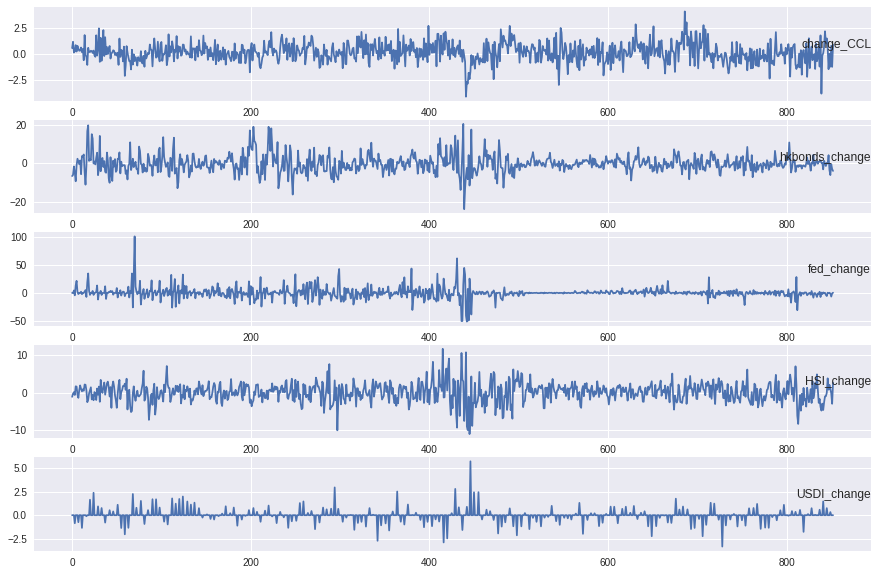

In [64]:
# load dataset
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5]
i = 1
# plot each column
plt.figure(figsize=(15,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [0]:
# convert series to supervised learning
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(df) is list else df.shape[1]
  cols, names = list(), list()
  col_name = df.columns
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('%s(t-%d)' % (col_name[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('%s(t)' % (col_name[j])) for j in range(n_vars)]
    else:
      names += [('%s(t+%d)' % (col_name[j], i)) for j in range(n_vars)]
	# put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [84]:
data.columns

Index([u'change_CCL', u'hkbonds_change', u'fed_change', u'HSI_change',
       u'DJIA_change', u'USDI_change'],
      dtype='object')

In [94]:
reframed = series_to_supervised(data, 2, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[13,14,15,16,17]], axis=1, inplace=True)
reframed.head()

,change_CCL(t-2),hkbonds_change(t-2),fed_change(t-2),HSI_change(t-2),DJIA_change(t-2),USDI_change(t-2),change_CCL(t-1),hkbonds_change(t-1),fed_change(t-1),HSI_change(t-1),DJIA_change(t-1),USDI_change(t-1),change_CCL(t)
Date,,,,,,,,,,,,,
2017-04-16,0.569321,-6.586486,0.000000,-1.110520,-0.244676,0.000000,1.178242,-5.992937,0.000000,-0.285484,-0.351975,0.000000,0.131087
2017-04-09,1.178242,-5.992937,0.000000,-0.285484,-0.351975,0.000000,0.131087,-1.574320,4.426230,0.131712,0.003038,0.000000,0.256275
2017-04-02,0.131087,-1.574320,4.426230,0.131712,0.003038,0.000000,0.256275,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142,0.854927
2017-03-26,0.256275,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142,0.854927,-9.317060,13.345196,1.709981,-0.985139,0.000000,0.225839
2017-03-19,0.854927,-9.317060,13.345196,1.709981,-0.985139,0.000000,0.225839,-0.997606,21.645022,1.624340,0.021167,0.000000,0.783237


In [95]:
reframed.shape

(851, 13)

In [0]:
train = reframed[reframed.index < '2016-01-01'].values
test = reframed[reframed.index > '2015-12-31'].values

In [0]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [0]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [99]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((783, 1, 12), (783,), (68, 1, 12), (68,))


In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [103]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 783 samples, validate on 68 samples
Epoch 1/50
 - 0s - loss: 0.7624 - val_loss: 0.6369
Epoch 2/50
 - 0s - loss: 0.7413 - val_loss: 0.6328
Epoch 3/50
 - 0s - loss: 0.7300 - val_loss: 0.6340
Epoch 4/50
 - 0s - loss: 0.7217 - val_loss: 0.6347
Epoch 5/50
 - 0s - loss: 0.7146 - val_loss: 0.6370
Epoch 6/50
 - 0s - loss: 0.7085 - val_loss: 0.6408
Epoch 7/50
 - 0s - loss: 0.7030 - val_loss: 0.6432
Epoch 8/50
 - 0s - loss: 0.6984 - val_loss: 0.6458
Epoch 9/50
 - 0s - loss: 0.6940 - val_loss: 0.6478
Epoch 10/50
 - 0s - loss: 0.6892 - val_loss: 0.6509
Epoch 11/50
 - 0s - loss: 0.6859 - val_loss: 0.6524
Epoch 12/50
 - 0s - loss: 0.6823 - val_loss: 0.6543
Epoch 13/50
 - 0s - loss: 0.6791 - val_loss: 0.6555
Epoch 14/50
 - 0s - loss: 0.6763 - val_loss: 0.6563
Epoch 15/50
 - 0s - loss: 0.6731 - val_loss: 0.6575
Epoch 16/50
 - 0s - loss: 0.6700 - val_loss: 0.6601
Epoch 17/50
 - 0s - loss: 0.6674 - val_loss: 0.6613
Epoch 18/50
 - 0s - loss: 0.6642 - val_loss: 0.6616
Epoch 19/50
 - 0s - loss: 0.

 - 0s - loss: 0.5848 - val_loss: 0.6872
Epoch 45/50
 - 0s - loss: 0.5830 - val_loss: 0.6881
Epoch 46/50
 - 0s - loss: 0.5791 - val_loss: 0.6882
Epoch 47/50
 - 0s - loss: 0.5788 - val_loss: 0.6887
Epoch 48/50
 - 0s - loss: 0.5742 - val_loss: 0.6884
Epoch 49/50
 - 0s - loss: 0.5711 - val_loss: 0.6875
Epoch 50/50
 - 0s - loss: 0.5678 - val_loss: 0.6851


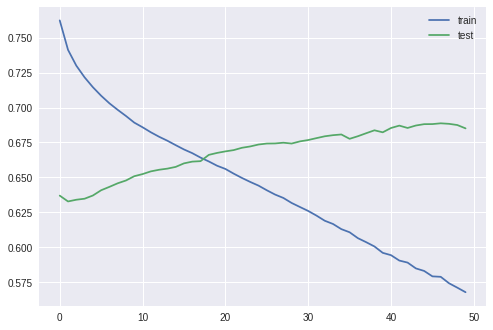

In [104]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], [1], test_X.shape[2]))

ValueError: ignored

In [111]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: ignored

In [107]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

NameError: ignored